In [9]:
from utils import *
from datasets import *
from networks import *
from losses import *

# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets
from sklearn.decomposition import PCA

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
# !pip install celluloid

## Test 1: Supervised training

Do representation split?

In [14]:
# Setting up data
dataset = DataSupervised(id='circles')
X, y = dataset.full()
dataloader = DataLoader(dataset, batch_size=200,
                        shuffle=True, num_workers=0)

# Setting up model training
model = NNClassifier(hidden=(10,))
lays_ = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
pca = PCA(n_components=2)
epochs = 100

/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.layers[-1](x))
/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(y)


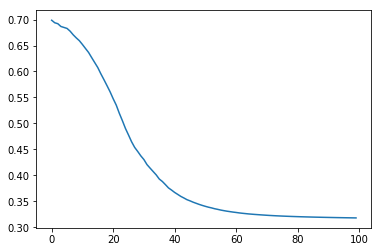

([<matplotlib.lines.Line2D at 0x7f2c01f9d320>], None)

In [15]:
losses = []
sup_data = [[] for i in range(5)]
for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):
        
#       import pdb; pdb.set_trace()
        X_batch, y_batch = sample_batched
        #Precit the output for Given input
        y_pred = model.forward(X_batch)
        #Compute Cross entropy loss
        loss = criterion(y_pred,y_batch)
        #Add loss to the list
        losses.append(loss.item())
        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 2 == 0):
            lays = model.forward_visible(X)
            for i, l in enumerate(lays):
                sup_data[i].append(pca.fit(l).transform(l))

plt.plot(losses), plt.show()

In [16]:
for i in range(lays_):
    separability(sup_data[i], y.numpy())

0.54
0.515
0.515
1.0
1.0


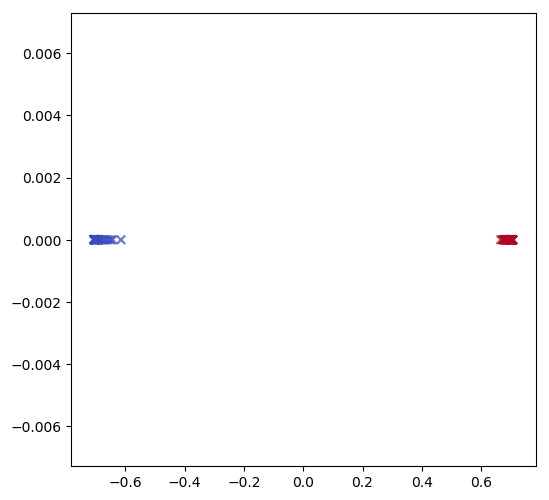

In [17]:
data = sup_data[4]
plt.figure(figsize=(6,6),dpi=100)
plt.scatter(data[-1][:,0], data[-1][:,1], c=y, marker='x', cmap=plt.cm.coolwarm, alpha=0.5)

Saved to supervised-representation-learning.mp4 in 16.525788068771362 seconds


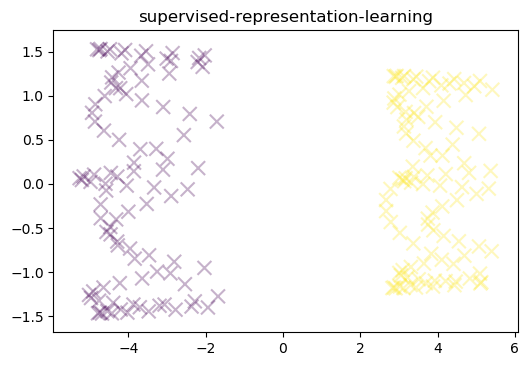

In [18]:
generate_video(sup_data[3], y,'supervised-representation-learning', res=100)

video progress: 87.50


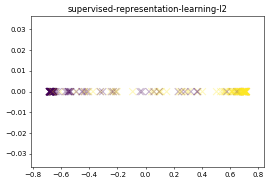

In [7]:
# To generate video rendering for all layers
# dicts = {0: 'input', 1: 'l1_pre', 2:'l1', 3:'l2_pre', 4:'l2'}
# for i in tqdm(range(4,5)):
#     generate_video(sup_data[i], y,'supervised-representation-learning-'+dicts[i], res=100)

/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.layers[-1](x))
/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


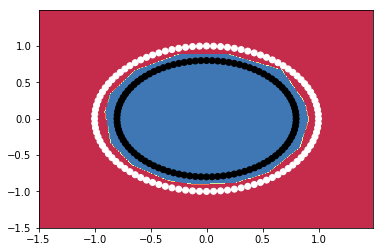

In [12]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.predict(x)
    return ans.numpy()

def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    
    
plot_decision_boundary(lambda x : predict(x) ,X.numpy(), y.numpy())

## Test 2: Training with only positive examples

Do representations collapse?

In [25]:
# Setting up data
dataset = DataUnsupervised(id='circles')
X, y = dataset.full()
dataloader = DataLoader(dataset, batch_size=2,
                        shuffle=True, num_workers=0)

# Setting up model training
model = NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
pca = PCA(n_components=2)
epochs = 10


100


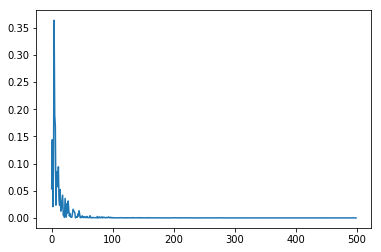

In [26]:
#List to store losses
losses = []
data = []
pca = PCA(n_components=2)
for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):
        Xpos, Xneg = sample_batched
        z_pos, z_neg = model.forward(Xpos), model.forward(Xneg)
#         import pdb;pdb.set_trace()
        loss = criterion(z_pos[0,:],z_pos[1,:]) + criterion(z_neg[0,:],z_neg[1,:])
        losses.append(loss.item())

        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 5 == 0):
            lays = model.forward_visible(X)
            out = pca.fit(lays[3]).transform(lays[3])
            data.append(out)
    
print(len(data))
plt.plot(losses)

Saved to representation-collapse.mp4 in 17.19847583770752 seconds


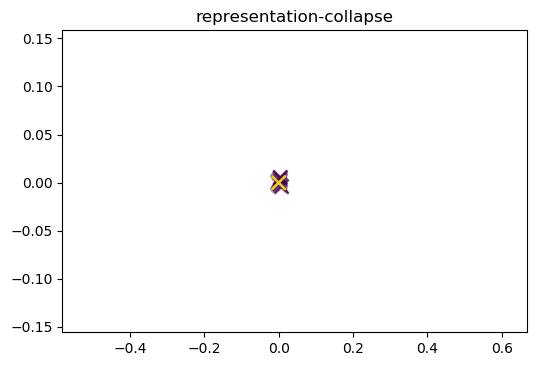

In [27]:
generate_video(data, y,'representation-collapse')

## Test 3: SimCLR style learning

https://arxiv.org/pdf/2002.05709.pdf

In [2]:
# Setting up data
dataset = DataUnsupervised(id='circles')
X, y = dataset.full()
bs = 20
dataloader = DataLoader(dataset, batch_size=bs,
                        shuffle=True, num_workers=0)

# Setting up model training
model = NN(hidden=(10,10,5))
lays_ = 6
criterion = nn.CosineSimilarity(dim=0, eps=1e-6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pca = PCA(n_components=2)
epochs = 400
xnt = NTXentLoss(device='cpu',batch_size=20, temperature=1, use_cosine_similarity=True)

/home/surya/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


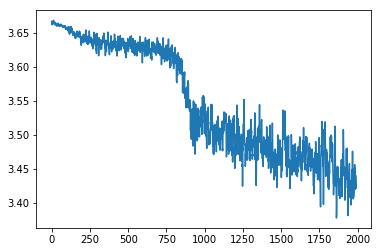

In [3]:
#List to store losses
losses = []
sup_data = [[] for i in range(lays_)]
style='simclr'
pca = PCA(n_components=2)
for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):
        Xpos, Xneg = sample_batched
        z_pos, z_neg = model.forward(Xpos), model.forward(Xneg)
        loss = xnt(z_pos,z_neg)
        
        losses.append(loss.item())

        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 5 == 0):
            lays = model.forward_visible(X)
            for i, l in enumerate(lays):
                sup_data[i].append(pca.fit(l).transform(l))
    
# print(len(data))
plt.plot(convolve(losses,10))

In [4]:
for i in range(lays_):
    separability(sup_data[i], y.numpy())

0.515
0.57
0.505
0.51
0.51
0.535


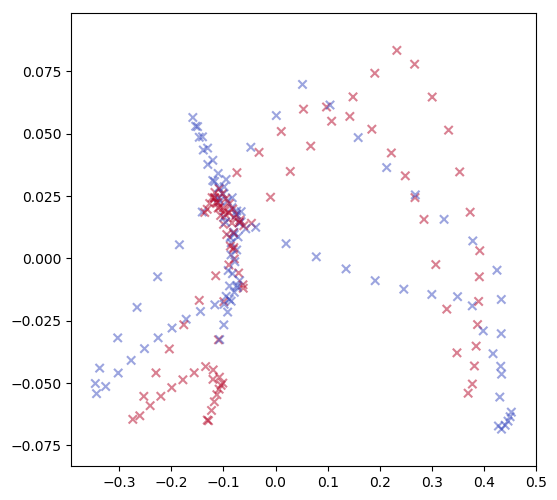

In [5]:
data = sup_data[-1]
plt.figure(figsize=(6,6),dpi=100)
plt.scatter(data[-1][:,0], data[-1][:,1], c=y, marker='x', cmap=plt.cm.coolwarm, alpha=0.5)

Saved to simclr.mp4 in 18.298112630844116 seconds


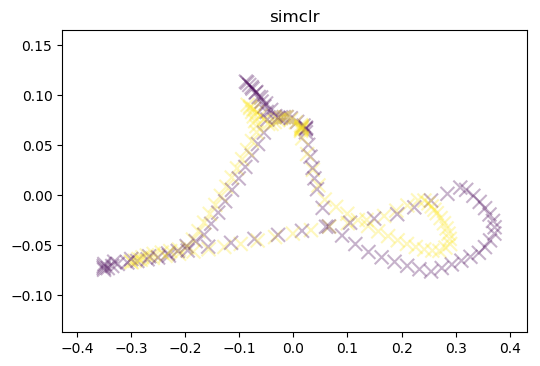

In [8]:
generate_video(sup_data[-1][:100], y,'simclr')